# Klasifikasi Gambar Cangkang dan Kerikil Menggunakan Transfer Learning GoogLeNet (Inception)

> Bondan Tiur Mahendra


##### 🎯 Pendahuluan: Mengapa Menggunakan *Deep Learning*?

Klasifikasi gambar secara tradisional (menggunakan ekstraksi fitur manual) sering kali tidak akurat. Kita menggunakan **Deep Learning** karena model ini secara otomatis dapat mempelajari **hierarki fitur yang kompleks** dari data mentah, memungkinkan diskriminasi yang sangat akurat antara objek yang bentuknya mirip, seperti cangkang (Shells) dan kerikil (Pebbles).

---

#####🚀 Transfer Learning: Memanfaatkan Kecerdasan yang Sudah Ada

Melatih model *deep learning* dari nol memerlukan dataset yang masif dan waktu komputasi yang sangat lama. Solusinya adalah **Transfer Learning**:

* **Definisi:** Mengambil model yang sudah dilatih (pra-terlatih) pada dataset yang sangat besar (seperti **ImageNet** yang berisi jutaan gambar umum) dan mengadaptasinya untuk tugas yang lebih spesifik (klasifikasi Shells vs. Pebbles).
* **Keuntungan:** Menghemat waktu, mengurangi kebutuhan data pelatihan, dan menghasilkan kinerja yang sangat tinggi.

---

##### 🧠 GoogLeNet (InceptionV3): Arsitektur Pilihan

Proyek ini memanfaatkan arsitektur **InceptionV3**, salah satu versi lanjutan dari model **GoogLeNet**.

* **Konsep Inti:** InceptionV3 menggunakan **Modul Inception** yang memungkinkan jaringan untuk melakukan beberapa operasi konvolusi dengan ukuran *kernel* yang berbeda secara paralel, kemudian menggabungkan hasilnya. Ini membuat jaringan lebih "lebar" (banyak fitur) dan lebih efisien secara komputasi.
* 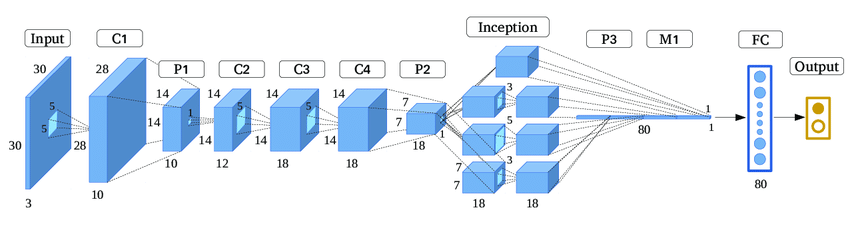

---

##### 🛠️ *Pipeline* Proyek

Proses klasifikasi kami mengikuti langkah-langkah *machine learning* standar, dengan penekanan khusus pada penyiapan data untuk Transfer Learning:

1.  **Pengunduhan Data:** Menggunakan pustaka `opendatasets` untuk mengunduh dataset dari Kaggle.
2.  **Preprocessing & Augmentasi:** Menggunakan `ImageDataGenerator` untuk:
    * **Normalisasi** piksel (0 hingga 1).
    * **Augmentasi Data** (rotasi, *zoom*, *flip*) pada data pelatihan untuk meningkatkan ketahanan (*robustness*) model.
3.  **Pembangunan Model:** Membekukan lapisan dasar InceptionV3 dan melatih lapisan `Dense` biner baru.
4.  **Evaluasi:** Mengukur kinerja model menggunakan **Akurasi, Presisi, Recall, dan *Confusion Matrix***.

In [ ]:
!pip install opendatasets

## Import Library

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/vencerlanz09/shells-or-pebbles-an-image-classification-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bondantm
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/shells-or-pebbles-an-image-classification-dataset


100%|██████████| 195M/195M [00:00<00:00, 1.03GB/s]




* Penjelasan: Mengunduh sebuah dataset dari platform Kaggle langsung ke Colab.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix


import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

* Penjelasan:
### 🛠️ Pustaka untuk Visualisasi & Evaluasi

Bagian pertama mengimpor alat-alat standar untuk analisis data, visualisasi, dan evaluasi performa model:

* `import matplotlib.pyplot as plt`: Mengimpor **Matplotlib**, pustaka dasar untuk membuat plot dan grafik. Ini digunakan untuk memvisualisasikan data, hasil pelatihan, atau kurva performa.
* `import numpy as np`: Mengimpor **NumPy**, pustaka fundamental untuk komputasi numerik di Python. Ini penting untuk menangani array dan matriks data, terutama untuk data gambar.
* `from sklearn.metrics import classification_report`: Mengimpor **`classification_report`** dari scikit-learn. Ini digunakan untuk menghasilkan laporan teks yang merangkum performa klasifikasi model (termasuk metrik **Precision, Recall, dan F1-score**).
* `import seaborn as sns`: Mengimpor **Seaborn**, pustaka visualisasi yang dibangun di atas Matplotlib. Ini sering digunakan untuk membuat plot statistik yang lebih estetis, seperti visualisasi matriks kebingungan.
* `from sklearn.metrics import confusion_matrix`: Mengimpor **`confusion_matrix`** dari scikit-learn. Ini menghitung matriks yang digunakan untuk mengevaluasi akurasi klasifikasi, menunjukkan jumlah prediksi yang benar dan salah untuk setiap kelas.

---

### 🧠 Pustaka untuk Model Deep Learning (TensorFlow/Keras)

Bagian ini mengimpor komponen inti dari **TensorFlow** dan **Keras** untuk membangun dan melatih model *deep learning*:

* `import tensorflow as tf`: Mengimpor **TensorFlow**, *framework* *deep learning* utama.
* `from tensorflow.keras.applications.inception_v3 import InceptionV3`: Mengimpor model **InceptionV3**. Ini adalah arsitektur **Jaringan Saraf Tiruan Konvolusional (CNN)** yang sudah dilatih sebelumnya pada dataset **ImageNet**. Ini digunakan sebagai *base model* untuk **Transfer Learning**.
* `from tensorflow.keras.preprocessing.image import ImageDataGenerator`: Mengimpor **`ImageDataGenerator`**. Ini adalah alat Keras untuk **Augmentasi Data (Data Augmentation)** *on-the-fly* (seperti memutar, membalik, atau *zoom* gambar) dan untuk memuat data gambar dari direktori dalam format yang siap untuk model (*batching*).
* `from tensorflow.keras.layers import Dense, GlobalAveragePooling2D`: Mengimpor *layer-layer* Keras yang akan ditambahkan ke *base model* InceptionV3:
    * **`Dense`**: Lapisan *fully connected* (padat), biasanya digunakan sebagai lapisan *output* akhir untuk klasifikasi.
    * **`GlobalAveragePooling2D`**: Lapisan yang mengurangi dimensi spasial dari peta fitur masukan dengan mengambil rata-rata setiap peta fitur. Ini bertindak sebagai pengganti lapisan *flatten* yang mengurangi jumlah parameter secara drastis.
* `from tensorflow.keras.models import Model`: Mengimpor kelas **`Model`**. Ini digunakan untuk mendefinisikan model Keras yang kompleks, terutama ketika membuat model Transfer Learning dengan menghubungkan *base model* (InceptionV3) dengan lapisan-lapisan baru yang Anda tambahkan.



## Loading and Processing Data

In [ ]:
# Define image size and batch size
img_width, img_height = 299, 299 # InceptionV3 requires 299x299 input size
batch_size = 32

# Define data directories
# Assuming /content/image contains subdirectories named 'Pebbles' and 'Shells'
train_data_dir = '/content/image'
validation_data_dir = '/content/image' # Using the same directory for simplicity, assuming it contains both classes

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # Split data for training and validation

# Preprocessing for validation data (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary', # Use 'binary' for binary classification
    subset='training') # Specify training subset

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary', # Use 'binary' for binary classification
    subset='validation') # Specify validation subset

Found 3428 images belonging to 2 classes.
Found 856 images belonging to 2 classes.


* Penjelasan:
### 🖼️ Pengaturan Awal (Hyperparameters)

Baris-baris ini mengatur variabel dasar yang akan digunakan di seluruh proses *preprocessing*:

* `img_width, img_height = 299, 299`: Mendefinisikan **ukuran input** yang wajib untuk model **InceptionV3**. Semua gambar akan diubah ukurannya menjadi $299 \times 299$ piksel.
* `batch_size = 32`: Menentukan jumlah gambar yang akan diproses pada setiap langkah (batch) selama pelatihan. Menggunakan *batch size* $32$ adalah praktik umum.
* `train_data_dir = '/content/image'` dan `validation_data_dir = '/content/image'`: Menentukan **lokasi direktori** tempat gambar pelatihan dan validasi Anda berada. Dalam kasus ini, diasumsikan kedua subset data (pelatihan dan validasi) akan diambil dari direktori yang sama (`/content/image`) menggunakan fitur *splitting* dari `ImageDataGenerator`.

---

### 🔄 Augmentasi dan Preprocessing Data

Bagian ini menggunakan **`ImageDataGenerator`** dari Keras untuk menyiapkan data:

#### 1. `train_datagen` (Pelatihan)

* `rescale=1./255`: Semua nilai piksel (yang awalnya berkisar dari 0 hingga 255) dinormalisasi (dibagi dengan 255) sehingga berada dalam rentang **0 hingga 1**. Ini penting agar pelatihan model menjadi stabil.
* `shear_range=0.2`, `zoom_range=0.2`, `horizontal_flip=True`: Ini adalah teknik **Augmentasi Data**. Teknik ini secara acak memodifikasi gambar (menggeser, memperbesar/memperkecil, membalik secara horizontal) saat dimuat. Tujuannya adalah untuk **meningkatkan variasi** data pelatihan, membantu model belajar fitur yang lebih robust, dan mengurangi *overfitting*.
* `validation_split=0.2`: Mendefinisikan bahwa 20% dari total gambar di direktori akan dicadangkan sebagai data validasi.

#### 2. `validation_datagen` (Validasi)

* `rescale=1./255`: Hanya melakukan **normalisasi** yang sama. Data validasi **tidak boleh diaugmentasi** (*shear*, *zoom*, *flip*) karena harus mewakili kondisi data yang tidak dimodifikasi.
* `validation_split=0.2`: Menggunakan pengaturan *split* yang sama.

---

### 💾 Pembuatan Data Generator (Data Loading)

Setelah mendefinisikan cara memproses data, bagian ini menggunakan fungsi **`flow_from_directory`** untuk memuat data dari disk:

#### 1. `train_generator`

* `train_datagen.flow_from_directory(...)`: Memuat gambar dari `train_data_dir`.
* `target_size=(img_width, img_height)`: Mengubah ukuran semua gambar menjadi $299 \times 299$.
* `batch_size=batch_size`: Memuat $32$ gambar setiap saat.
* `class_mode='binary'`: Karena ini adalah masalah klasifikasi dua kelas ('Pebbles' dan 'Shells'), mode ini memastikan label kelas dikodekan sebagai **0 atau 1**.
* `subset='training'`: Secara spesifik hanya mengambil subset data yang dicadangkan (80%) untuk pelatihan, berdasarkan `validation_split=0.2` yang ditetapkan di `train_datagen`.

#### 2. `validation_generator`

* `validation_datagen.flow_from_directory(...)`: Memuat gambar dari `validation_data_dir`.
* `subset='validation'`: Secara spesifik mengambil subset data yang dicadangkan (20%) untuk validasi, berdasarkan `validation_split=0.2` yang ditetapkan di `validation_datagen`.



In [ ]:
def collect_data_from_generator(generator):
    """Collects all data from a generator into arrays."""
    all_data = []
    all_labels = []
    for i in range(len(generator)):
        batch_data, batch_labels = generator[i]
        all_data.append(batch_data)
        all_labels.append(batch_labels)
    return np.concatenate(all_data), np.concatenate(all_labels)

# Collect training data
print("Collecting training data...")
X_train, y_train = collect_data_from_generator(train_generator)
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")

# Collect validation data (which can be used as a test set)
print("Collecting validation data...")
X_test, y_test = collect_data_from_generator(validation_generator)
print(f"Validation data shape: {X_test.shape}, Validation labels shape: {y_test.shape}")

Training data shape: (3428, 299, 299, 3), Training labels shape: (3428,)
Validation data shape: (856, 299, 299, 3), Validation labels shape: (856,)


* Penjelasan: Menggunakan fungsi untuk mengambil semua data gambar dan label yang telah disiapkan oleh ImageDataGenerator Keras dari disk dan memuatnya sepenuhnya ke dalam array NumPy di memori.

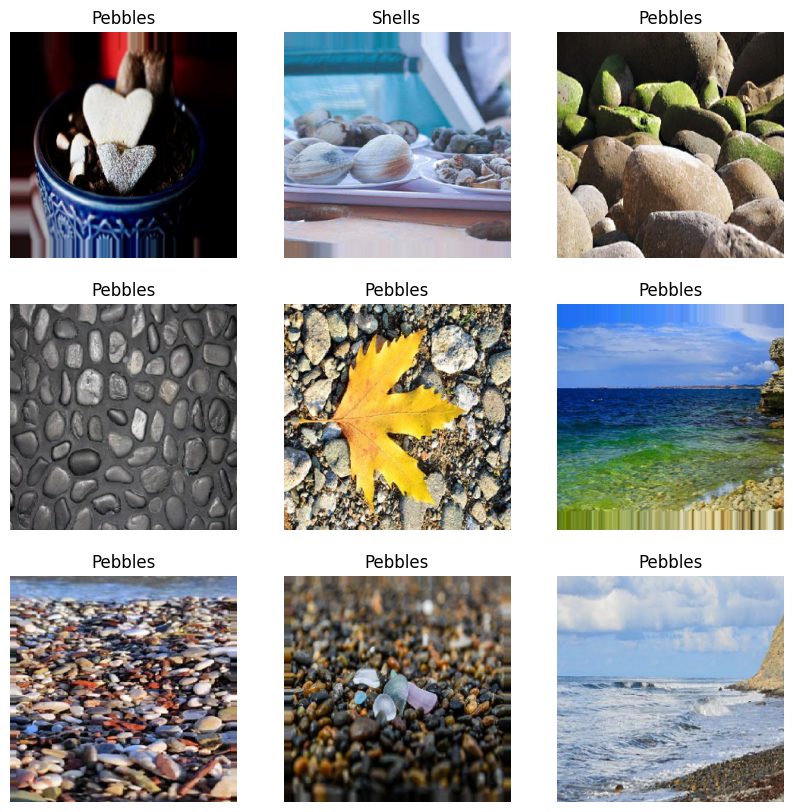

In [ ]:
# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Display the first few images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    # Get the class name from the generator's class_indices
    if labels[i] == 0:
        plt.title('Pebbles')
    else:
        plt.title('Shells')
    plt.axis("off")
plt.show()

* Penjelasan: Memvisualisasikan contoh-contoh gambar pertama dari batch data pelatihan untuk memverifikasi bahwa data generator telah memuat dan memproses gambar dengan benar.

## Load the InceptionV3 model

In [ ]:
# Load the InceptionV3 model with pre-trained ImageNet weights
# Exclude the top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a dense layer with a sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


* Penjelasan: Membangun model deep learning menggunakan Transfer Learning berdasarkan arsitektur InceptionV3.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

* Penjelasan: Menampilkan tabel yang merangkum arsitektur, lapisan-lapisan, dan jumlah parameter dari model yang baru Anda buat (model).

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10 # You can adjust the number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 125s 972ms/step - accuracy: 0.7609 - loss: 0.5120 - val_accuracy: 0.8870 - val_loss: 0.2504
Epoch 2/10
  1/107 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.8125 - loss: 0.4489

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8125 - loss: 0.4489 - val_accuracy: 0.8870 - val_loss: 0.2514
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 748ms/step - accuracy: 0.8467 - loss: 0.3672 - val_accuracy: 0.9026 - val_loss: 0.2369
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8438 - loss: 0.5034 - val_accuracy: 0.9135 - val_loss: 0.2296
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 79s 741ms/step - accuracy: 0.8660 - loss: 0.3318 - val_accuracy: 0.9399 - val_loss: 0.2039
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8438 - loss: 0.4129 - val_accuracy: 0.9387 - val_loss: 0.2054
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 79s 735ms/step - accuracy: 0.8614 - loss: 0.3229 - val_accuracy: 0.9303 - val_loss: 0.2038
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9688 - loss: 0.1900 - val_accuracy: 0.9255 - val_loss: 0.2014
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 750ms/step - accuracy: 0.8678 - loss: 0.3192 - val_accurac

* Penjelasan: Mengompilasi, melatih, dan mengevaluasi model deep learning InceptionV3 yang telah Anda buat untuk klasifikasi biner 'Shells atau Pebbles'.

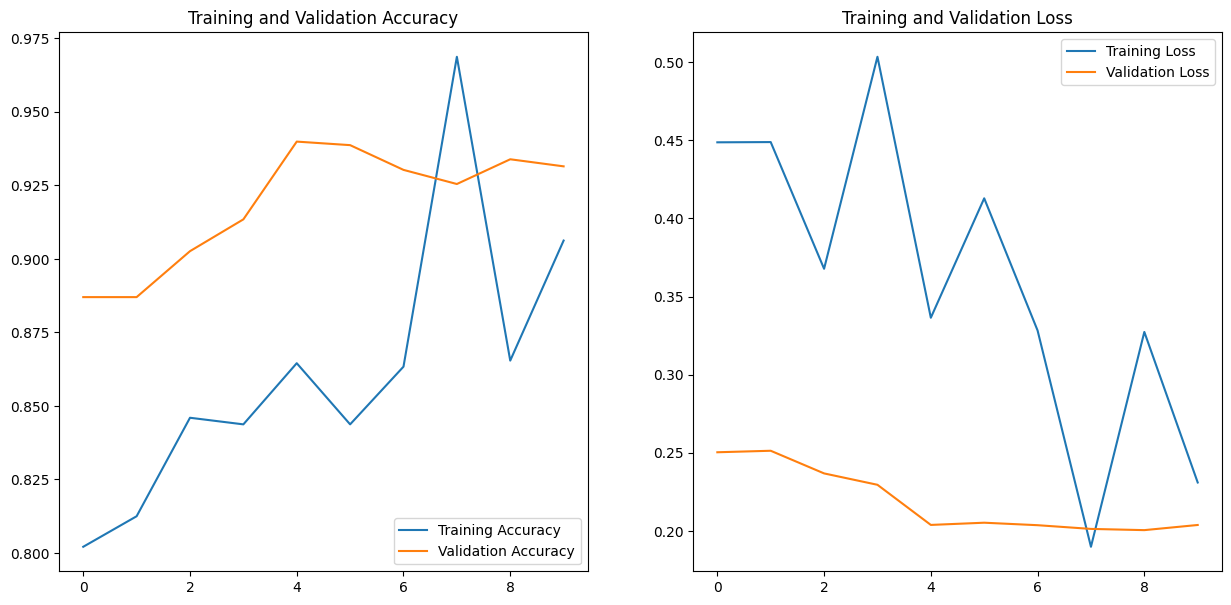

In [ ]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* Penjelasan: Memplot hasil pelatihan model yang disimpan dalam objek history. Visualisasi ini sangat penting untuk mendiagnosis performa model, terutama untuk mengidentifikasi overfitting atau underfitting.

In [ ]:
scores = model.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9335 - loss: 0.1806


* Penjelasan: Menghitung nilai kerugian (loss) dan metrik (dalam kasus Anda: akurasi) dari model pada seluruh dataset yang diberikan.

In [ ]:
# Make predictions on the test set
pred = model.predict(X_test)
# Convert predictions to binary labels (0 or 1)
pred = np.round(pred).flatten()

print(classification_report(y_test,pred,target_names = ['Pebbles','Shells']))

27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 365ms/step
              precision    recall  f1-score   support

     Pebbles       0.94      0.96      0.95       548
      Shells       0.92      0.89      0.91       308

    accuracy                           0.93       856
   macro avg       0.93      0.92      0.93       856
weighted avg       0.93      0.93      0.93       856



* Penjelasan: Membuat prediksi menggunakan model yang sudah dilatih pada data uji dan kemudian menampilkan laporan evaluasi kinerja secara rinci.

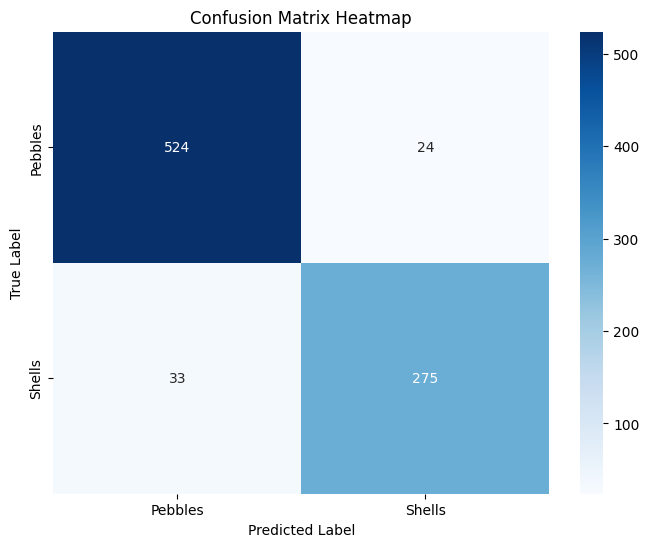

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pebbles', 'Shells'], yticklabels=['Pebbles', 'Shells'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

* Penjelasan: Membuat dan memvisualisasikan Confusion Matrix (Matriks Kebingungan) dari hasil prediksi model Anda dalam bentuk heatmap.

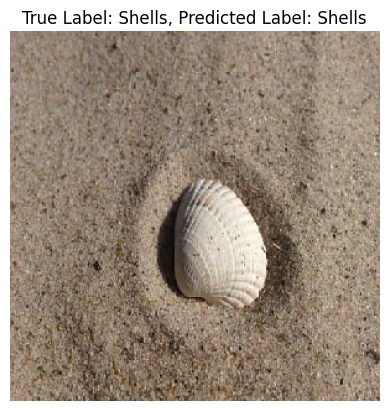

In [ ]:
# Select a random image from the test set
random_index = np.random.randint(0, len(X_test))
sample_image = X_test[random_index]
sample_label = y_test[random_index]
sample_prediction = pred[random_index]

# Display the image
plt.imshow(sample_image)
plt.title(f"True Label: {'Shells' if sample_label == 1 else 'Pebbles'}, Predicted Label: {'Shells' if sample_prediction == 1 else 'Pebbles'}")
plt.axis("off")
plt.show()